# Atividades Práticas Supervisionadas(APS)

## Importando Bibiotecas

In [61]:
# Treinamento
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel
from torch.utils.data import DataLoader, TensorDataset

# Obter dados no Reddit
import praw

# Manipulação e Visualização dos dados 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Demais bibliotecas
import os
import re
import unicodedata
from datetime import datetime, timedelta


## Pré-processamento dos Dados

### Funções para limpar os textos

In [2]:
def Limpeza_dados(texto):
    # Remover links
    texto = re.sub(r'http\S+', '', texto)
    # Remover menções a usuários
    texto = re.sub(r'@\w+', '', texto)
    # Remover caracteres especiais e números
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    # Remover espaços extras
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()
def remover_acentos(texto):
    return ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')


### Carregar dados do arquivo e limpar os Textos

In [62]:
df = pd.read_excel("../../data/bd_aps.xlsx")
df = df[["texto", "classificacao"]]

tweets = df['texto'].apply(remover_acentos)
tweets = df['texto'].apply(Limpeza_dados)
classes = df['classificacao']

print("Número de tweets após a remoção:", len(tweets)) 
print("Número de rótulos após a remoção:", len(classes))



Número de tweets após a remoção: 200
Número de rótulos após a remoção: 200


## Treinando o Modelo

### Carregar o tokenizer e o modelo pré-treinado BERT

In [4]:
model_name = 'neuralmind/bert-base-portuguese-cased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Conjunto de dados de Treinamento

In [5]:
train_sentences = tweets.tolist()
train_labels = torch.tensor(classes.tolist())  # 1 para positivo, 0 para negativo

### Tokenizar os dados de treinamento

In [6]:
encoded_dict = tokenizer(train_sentences, padding=True, truncation=True, max_length=256, return_tensors='pt')
input_ids = encoded_dict['input_ids']
attention_mask = encoded_dict['attention_mask']

### Criar o conjunto de dados de treinamento

In [8]:
train_dataset = TensorDataset(input_ids, attention_mask, train_labels)

### Definir hiperparâmetros de treinamento

In [9]:
batch_size = 200
learning_rate = 2e-5
epochs = 20

### Criar o DataLoader para o conjunto de dados de treinamento

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)

### Configurar otimizador e função de perda

In [11]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

### Treinando o modelo

In [12]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    total_loss = 0
    num_batches = len(train_loader)
    
    # Loop de treinamento
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Mover os dados para o dispositivo
        input_ids, attention_mask, labels = batch
        
        # Passagem para a frente
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Retropropagação e otimização
        loss.backward()
        optimizer.step()
        
        # Atualizar o progresso
        print(f"\rBatch [{batch_idx+1}/{num_batches}], Loss: {loss.item():.4f}", end="")
    
    # Calcular a média da perda
    avg_loss = total_loss / num_batches
    
    # Imprimir a média da perda
    print(f"\nAverage Loss: {avg_loss:.4f}")

Epoch 1/20
Batch [1/1], Loss: 0.6860
Average Loss: 0.6860
Epoch 2/20
Batch [1/1], Loss: 0.6493
Average Loss: 0.6493
Epoch 3/20
Batch [1/1], Loss: 0.6200
Average Loss: 0.6200
Epoch 4/20
Batch [1/1], Loss: 0.5756
Average Loss: 0.5756
Epoch 5/20
Batch [1/1], Loss: 0.5209
Average Loss: 0.5209
Epoch 6/20
Batch [1/1], Loss: 0.4581
Average Loss: 0.4581
Epoch 7/20
Batch [1/1], Loss: 0.4126
Average Loss: 0.4126
Epoch 8/20
Batch [1/1], Loss: 0.3547
Average Loss: 0.3547
Epoch 9/20
Batch [1/1], Loss: 0.3060
Average Loss: 0.3060
Epoch 10/20
Batch [1/1], Loss: 0.2695
Average Loss: 0.2695
Epoch 11/20
Batch [1/1], Loss: 0.2239
Average Loss: 0.2239
Epoch 12/20
Batch [1/1], Loss: 0.1903
Average Loss: 0.1903
Epoch 13/20
Batch [1/1], Loss: 0.1570
Average Loss: 0.1570
Epoch 14/20
Batch [1/1], Loss: 0.1343
Average Loss: 0.1343
Epoch 15/20
Batch [1/1], Loss: 0.1133
Average Loss: 0.1133
Epoch 16/20
Batch [1/1], Loss: 0.0935
Average Loss: 0.0935
Epoch 17/20
Batch [1/1], Loss: 0.0798
Average Loss: 0.0798
Epoch 

### Salvar o modelo treinado

In [16]:
output_model_file = "model.bin"
torch.save(model.state_dict(), output_model_file)
output_tokenizer_dir = "tokenizer_dir"
tokenizer.save_pretrained(output_tokenizer_dir)

('tokenizer_dir\\tokenizer_config.json',
 'tokenizer_dir\\special_tokens_map.json',
 'tokenizer_dir\\vocab.txt',
 'tokenizer_dir\\added_tokens.json',
 'tokenizer_dir\\tokenizer.json')

## Obtendo textos do Reddit e aplicando analise de sentimento

### Carregar os pesos e tokenizer do modelo treinado

In [17]:
model.load_state_dict(torch.load("model.bin"))
tokenizer = AutoTokenizer.from_pretrained('tokenizer_dir')
# Definir o modo de avaliação
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Funções para classificar sentimentos usando o modelo

In [45]:
def classify_sentiment(text, tokenizer, model):
    # Tokenização
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')

    # Passagem para a frente
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Obter a previsão do modelo
    _, preds = torch.max(outputs.logits, dim=1)

    # Converter a previsão em um sentimento
    if preds.item() == 1:
        return "Positivo"
    else:
        return "Negativo"


### Configurar as credenciais para acessar a API do Reddit

In [46]:
# Configurar as credenciais para acessar a API do Reddit
reddit = praw.Reddit(
    client_id="0LUIMHwzq6iTBcF4F4zGpQ",
    client_secret="AN90R4CXtXjCpEfXEEVCIKIjReY0NA",
    user_agent="aps",
)

### Lista de tópicos de interesse (palavras-chave)

In [47]:
# Lista de tópicos de interesse (palavras-chave)
topics = ["desmatamento", "incendios", "barragem", "chuva", "poluição"]
# Criar uma lista para armazenar os dados
data = []

### Busca o texto no Reddit e faz a analise de sentimentos

In [50]:
# Iterar sobre cada palavra-chave
for keyword in topics:
    # Contadores para postagens positivas e negativas
    positive_count = 0
    negative_count = 0
    
    # Iterar sobre os posts do Reddit relacionados à palavra-chave
    for submission in reddit.subreddit("all").search(keyword, sort="hot", time_filter="month", limit=20):
        if submission.selftext.strip() != "" or submission.url.strip() != "":
            print(keyword)
            print("Title:", submission.title)
            print("Selftext:", submission.selftext)
            print("URL:", submission.url)
            # Concatenar o título e o conteúdo do post
            text = submission.title + " " + submission.selftext
            text = remover_acentos(text)
            text = Limpeza_dados(text)
            # Classificar o sentimento do texto
            sentiment = classify_sentiment(text, tokenizer, model)
            print("Sentiment:", sentiment)
            # Atualizar os contadores com base no sentimento
            if sentiment == "Positivo":
                positive_count += 1
            elif sentiment == "Negativo":
                negative_count += 1
    # Calcular a porcentagem de notícias positivas e negativas
    total_count = positive_count + negative_count
    positive_percentage = (positive_count / total_count) * 100 if total_count > 0 else 0
    negative_percentage = (negative_count / total_count) * 100 if total_count > 0 else 0
    
    
     # Obter a data atual
    current_date = datetime.now().strftime("%Y-%m-%d")
    
    # Armazenar os resultados na lista de dados
    if keyword in topics:
        data.append([current_date, keyword, positive_percentage, negative_percentage])

desmatamento
Title: Desmatamento em áreas protegidas na Amazônia, como terras indígenas, tem a menor taxa em 9 anos, aponta Imazon
Selftext: 
URL: https://g1.globo.com/meio-ambiente/noticia/2024/01/22/desmatamento-em-areas-protegidas-na-amazonia-como-terras-indigenas-tem-a-menor-taxa-em-9-anos-aponta-imazon.ghtml
Sentiment: Negativo
desmatamento
Title: Lebrão invade o Brasil no rastro do desmatamento
Selftext: 
URL: https://territoriosecreto.com.br/lebrao-invade-o-brasil-no-rastro-do-desmatamento/
Sentiment: Negativo
desmatamento
Title: Simulador de voo permite denunciar desmatamento e garimpo ilegal na Amazônia | Em ação da Greenpeace, "Flying Guardians" é um mod dentro do Microsoft Flight Simulator que permite ao usuário usar o simulador como uma ferramenta ambiental
Selftext: 
URL: https://www.cnnbrasil.com.br/tecnologia/simulador-de-voo-denuncia-desmatamento-e-garimpo-na-amazonia/
Sentiment: Positivo
desmatamento
Title: Desmatamento: por que Brasil e Colômbia lideraram 'redução drá

### Salva os dados e sua classificação em um arquivo csv

In [53]:
# Criar um DataFrame com os dados
df = pd.DataFrame(data, columns=['Date', 'Keyword', 'Positive Percentage', 'Negative Percentage'])

# Salvar o DataFrame em um arquivo CSV
csv_file_path = r"..\..\data\reddit_sentiment_data.csv"
# Salvar o DataFrame em um arquivo CSV (modo append)
df.to_csv(csv_file_path, index=False, mode='a', header=not os.path.isfile(csv_file_path))

print("Dados salvos com sucesso no arquivo CSV.")

Dados salvos com sucesso no arquivo CSV.


## Visualização dos dados

In [63]:
# Ler o arquivo CSV
df = pd.read_csv(r"..\..\data\reddit_sentiment_data.csv")
# Converter a coluna Date para o tipo datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Keyword,Positive Percentage,Negative Percentage
0,2024-03-13,deforestation,71.428571,28.571429
1,2024-03-13,forestfires,0.000000,0.000000
2,2024-03-13,floods,5.000000,95.000000
3,2024-03-13,rain,25.000000,75.000000
4,2024-03-13,riverpollution,0.000000,0.000000


### Plotagem do Gráfico.

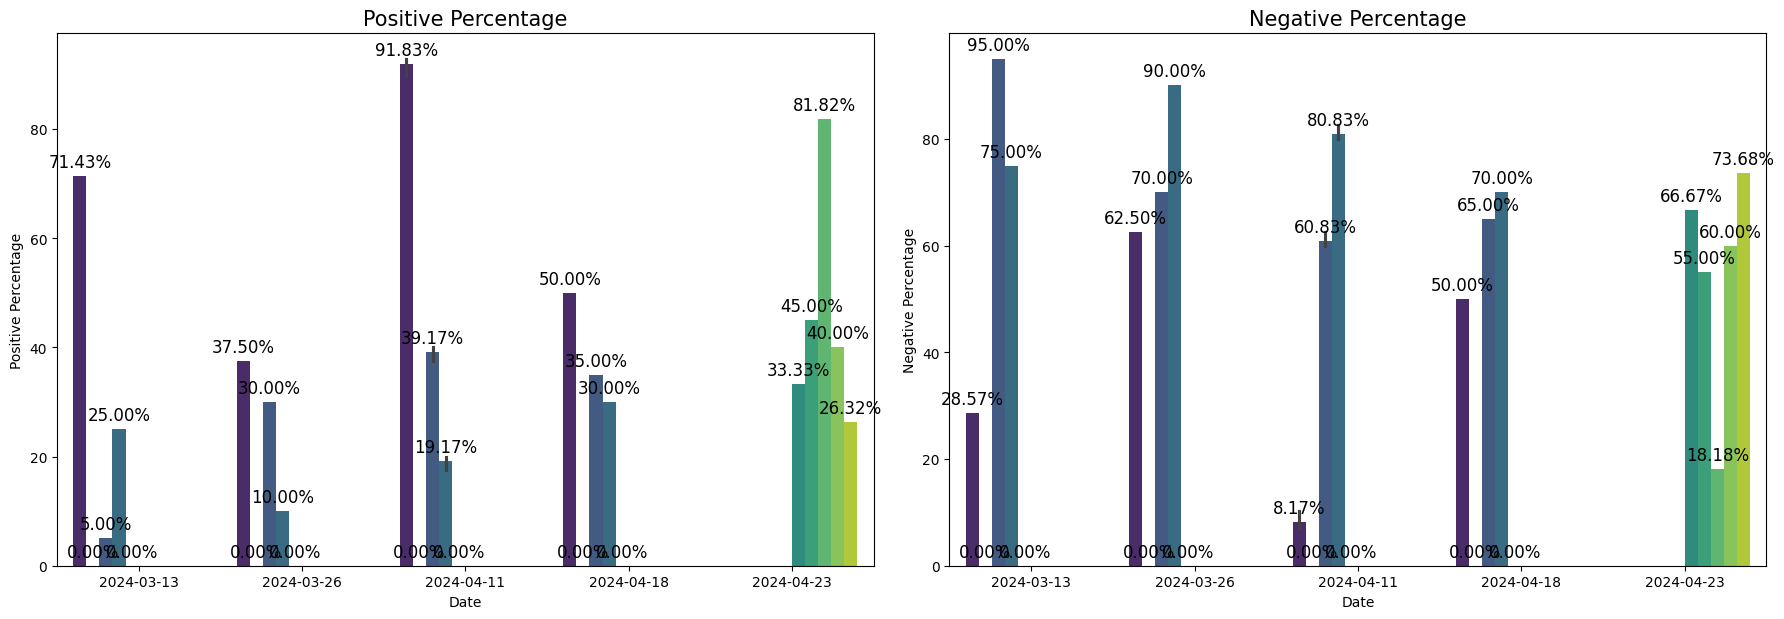

In [65]:
# Plot
# Tamanho da figura
plt.figure(figsize=(18, 30))

# Contador
A = 0

for i in df.columns.values[2:]:
    A += 1
    plt.subplot(5, 2, A)
    ax = sns.barplot(data=df.fillna('NaN'), x='Date', y=i, hue='Keyword', palette='viridis', legend=False)
    plt.title(i, fontsize=15)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)
    if A >= 7:
        plt.xticks(rotation=45)

# Layout
plt.tight_layout(h_pad=2)
plt.show()
